In [2]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
from matplotlib.colors import ListedColormap


#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'



import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc

2024-03-27 13:15:41.950902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
fp = '/rc_scratch/reba1583/CNN_daily_test3_fulldata/'
results = pd.read_csv(fp+'results.csv', index_col = 0)
model = tf.keras.models.load_model(fp+'model.keras')
val = pd.read_csv(fp+'val.csv', index_col = 0)
history = pd.read_csv(fp+'history.csv')


2024-03-27 13:15:46.773707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Summarize model

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 90, 32)       5504      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 144, 90, 32)       0         
                                                                 
 dropout (Dropout)           (None, 144, 90, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 90, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 144, 90, 32)       0         
                                                                 
 dropout_1 (Dropout)         (None, 144, 90, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 90, 64)       1

## Model history - loss functions

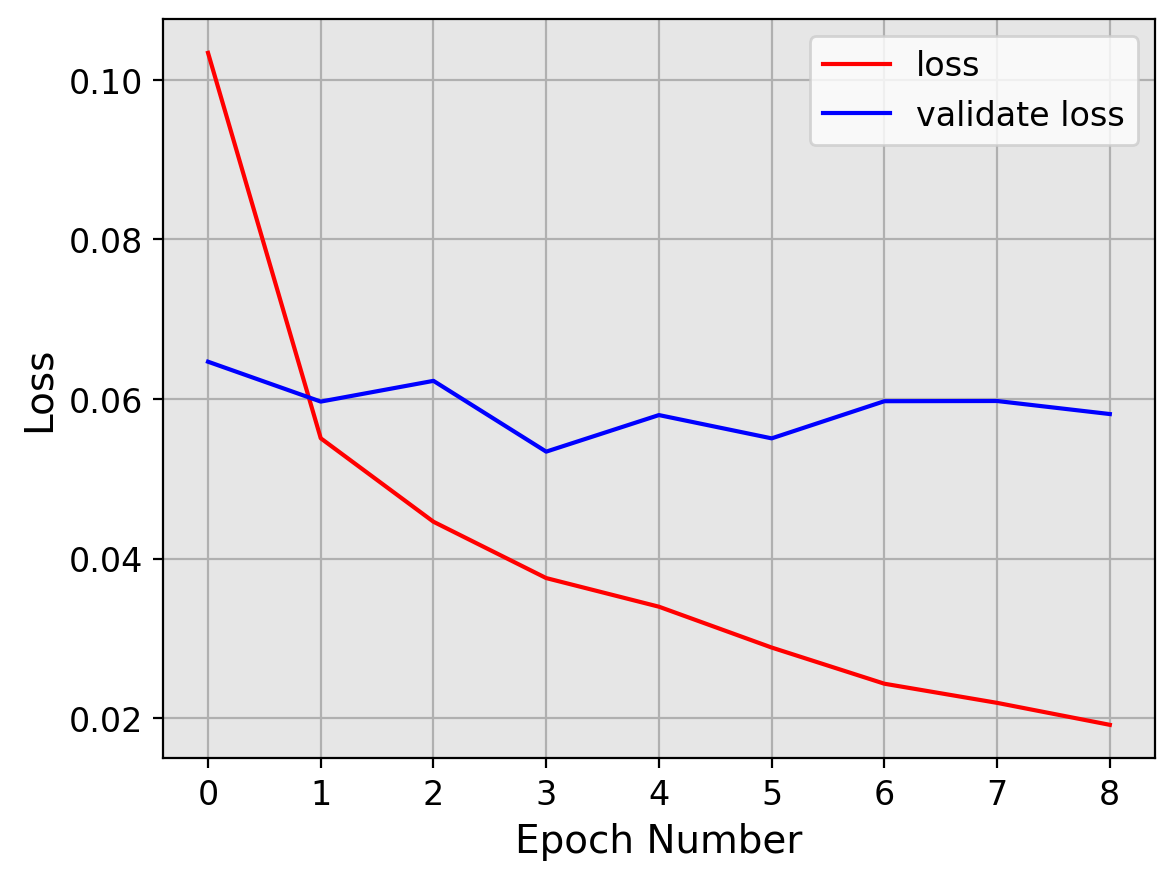

In [5]:
plt.plot(history['loss'],'-r', label = 'loss')
plt.plot(history['val_loss'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Performance Diagrams 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


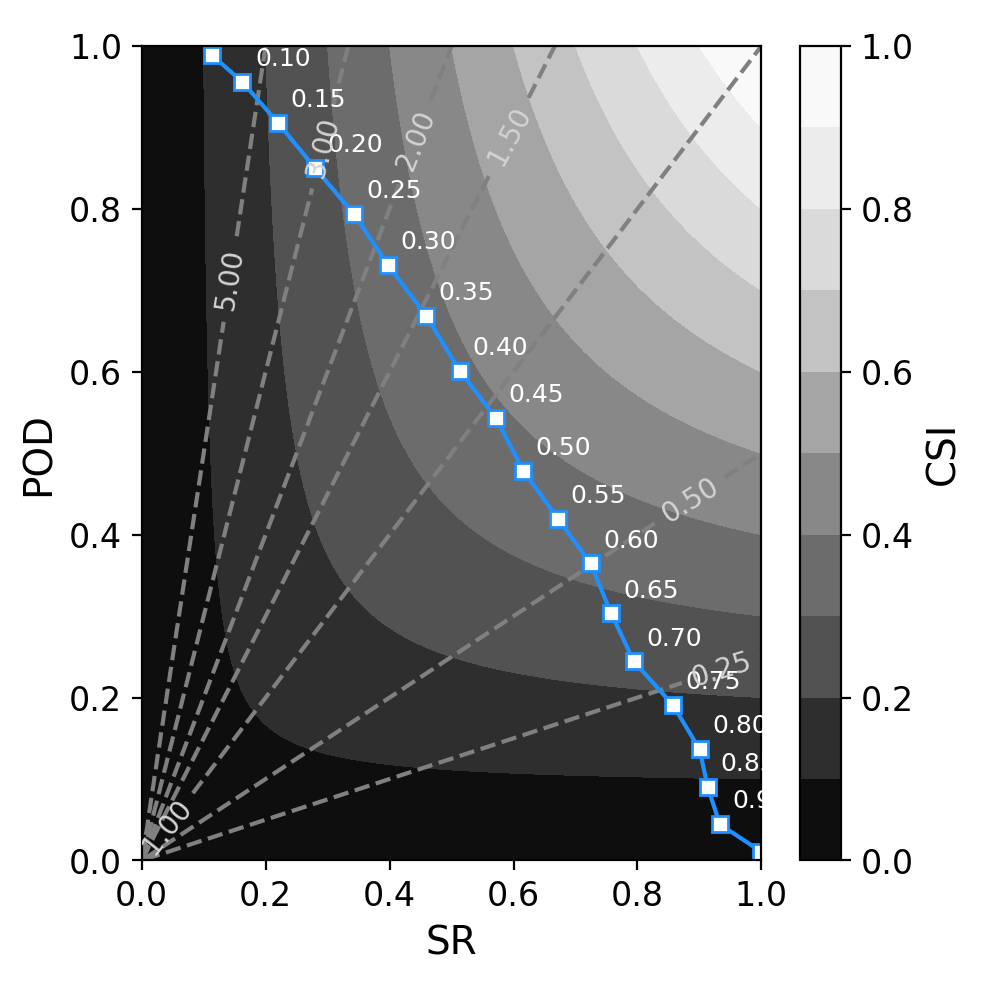

In [6]:
#ravel both
y_v_rav =np.array(val).ravel()
y_preds_rav = np.array(results).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout();

## Accuracy for AR versus no AR

In [7]:
cutoff = .45

In [8]:
predict = np.array(np.where(results>=cutoff,1,0))
#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(np.array(val),np.array(predict))

accuracy = get_acc(cont_table)
print('Percent of AR Correctly Detected = {}%'.format(np.round(cont_table['num_true_positives']/np.sum(np.array(val))*100,0)))
print('Percent of noAR Correctly Detected = {}%'.format(np.round(cont_table['num_true_negatives']/np.sum(np.where(np.array(val) ==0,1,0))*100,0)))
print('Binary Accuracy = {}%'.format(np.round(accuracy,0)))

print(cont_table)
print('number of true positives (actual): ' +str(np.sum(np.array(val))))
print('number of true negatives (actual): ' +str(np.sum(np.where(np.array(val) ==0,1,0))))

Percent of AR Correctly Detected = 54.0%
Percent of noAR Correctly Detected = 96.0%
Binary Accuracy = 93.0%
{'num_true_positives': 2046, 'num_false_positives': 1716, 'num_false_negatives': 1537, 'num_true_negatives': 38521}
number of true positives (actual): 3762
number of true negatives (actual): 40058


In [9]:
near = [[0,10],
       [1,11],
       [2, 12],
        [3,13],
        [4, 14],
        [5,15],
        [6,16],
        [7,17],
        [8,18],
        [9,19]]

counts = np.zeros(np.shape(np.array(predict)))
for n in np.arange(10):
    predict_region = np.array(predict[:,n])
    val_region = np.array(val.iloc[:,n])

    for l in range(len(val_region)):
        if (val_region[l]==1) & (np.max(predict[l,near[n]])==1):
                counts[l, n] = 1
print('relaxed landfalling AR regional count (land+ocean): '
+str(np.round((np.sum(counts,0)[0:10]/np.sum(np.array(val),0)[0:10])*100,0))
+'%     ')

relaxed landfalling AR regional count (land+ocean): [78. 74. 70. 74. 78. 74. 63. 73. 71. 81.]%     


In [10]:
near = [[9,0,1,],
       [0,1,2,],
       [1,2,3,],
        [2,3,4,],
        [3,4,5,],
        [4,5,6,],
        [5,6,7,],
        [6,7,8,],
        [7,8,9,],
        [8,9,0,]]

counts = np.zeros(np.shape(np.array(predict)))
for n in np.arange(10):
    predict_region = np.array(predict[:,n])
    val_region = np.array(val.iloc[:,n])

    for l in range(len(val_region)):
        if (val_region[l]==1) & (np.max(predict[l,near[n]])==1):
                counts[l, n] = 1
print('relaxed landfalling AR regional count (land+ land around): '
+str(np.round((np.sum(counts,0)[0:10]/np.sum(np.array(val),0)[0:10])*100,0))
+'%     ')

relaxed landfalling AR regional count (land+ land around): [81. 72. 76. 78. 70. 53. 55. 71. 69. 88.]%     


In [11]:
near = [[9,0,1,19,10,11],
       [0,1,2,10,11,12],
       [1,2,3,11,12,13],
        [2,3,4,12,13,14],
        [3,4,5,13,14,15],
        [4,5,6,14,15,16],
        [5,6,7,15,16,17],
        [6,7,8,16,17,18],
        [7,8,9,17,18,19],
        [8,9,0,18,19,10]]

counts = np.zeros(np.shape(np.array(predict)))
for n in np.arange(10):
    predict_region = np.array(predict[:,n])
    val_region = np.array(val.iloc[:,n])

    for l in range(len(val_region)):
        if (val_region[l]==1) & (np.max(predict[l,near[n]])==1):
                counts[l, n] = 1
print('relaxed landfalling AR regional count (land+ land and ocean around): '
+str(np.round((np.sum(counts,0)[0:10]/np.sum(np.array(val),0)[0:10])*100,0))
+'%     ')

relaxed landfalling AR regional count (land+ land and ocean around): [91. 88. 87. 88. 87. 88. 84. 86. 82. 93.]%     


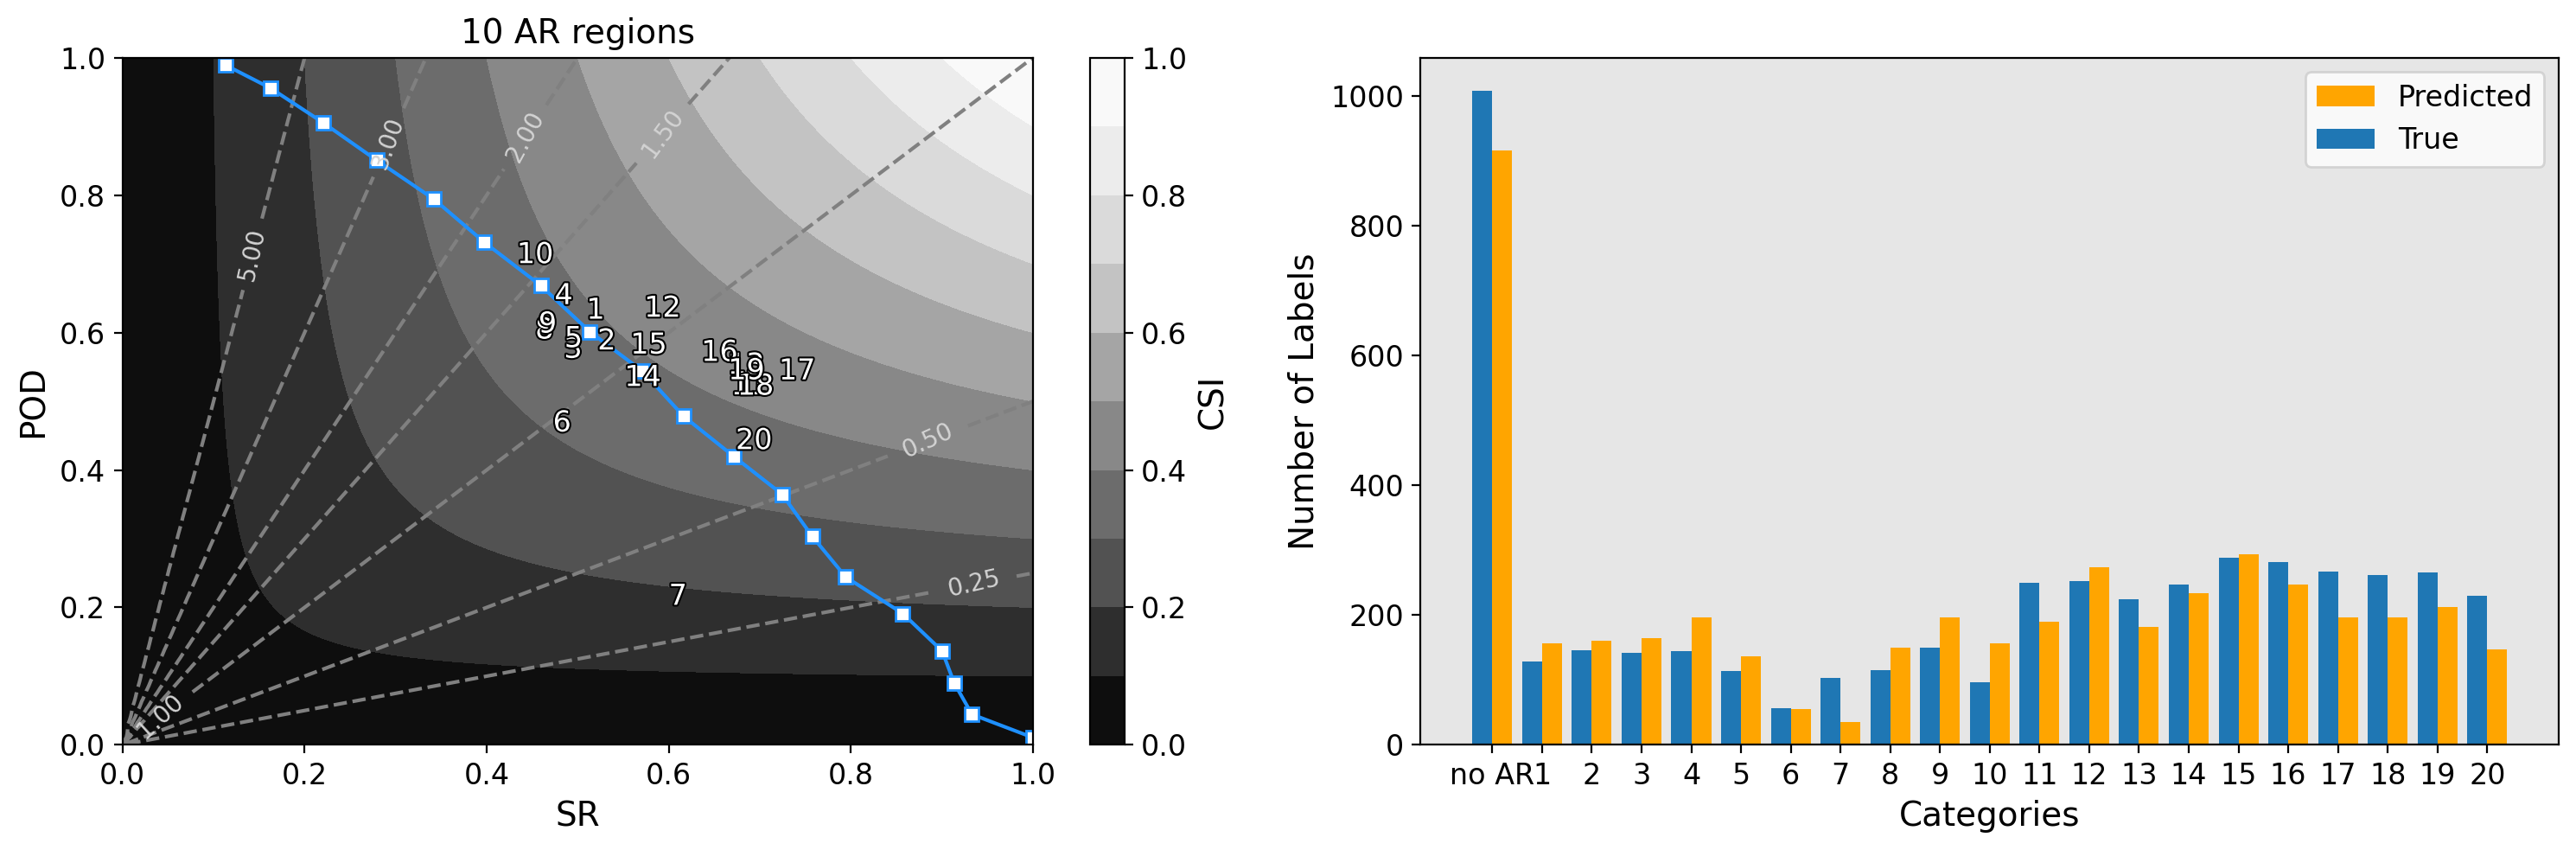

In [12]:
y_preds = np.where(results>=cutoff,1,0).ravel()
y_res = np.array(results).ravel()
y_val = np.array(val).ravel()
tp = np.zeros((20))
fp = np.zeros((20))
fn = np.zeros((20))
tn = np.zeros((20))

for n in np.arange(20):
    tp[n] = sum((predict[:,n]==1) & (np.array(val)[:,n] ==1))
    fp[n] = sum((predict[:,n]==1) & (np.array(val)[:,n] ==0))
    fn[n] = sum((predict[:,n]==0) & (np.array(val)[:,n] ==1))
    tn[n] = sum((predict[:,n]==0) & (np.array(val)[:,n] ==0))

#calc x,y of performance diagram 
pod= tp/(tp + fn)
sr = tp/(tp + fp)
csi = tp/(tp + fn + fp)

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp_total = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp_total = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn_total = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp_total.reset_state()
fp_total.reset_state()
fn_total.reset_state()

tp_total = tp_total(y_val,y_res )
fp_total = fp_total(y_val,y_res )
fn_total = fn_total(y_val,y_res )

#calc x,y of performance diagram 
pod_total = tp_total /(tp_total  + fn_total )
sr_total  = tp_total /(tp_total  + fp_total )
csi_total  = tp_total /(tp_total  + fn_total  + fp_total )



#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()

#plot it up  
make_performance_diagram_axis(ax[0])
ax[0].plot(np.array(sr_total),np.array(pod_total),'-s',color='dodgerblue',markerfacecolor='w')
# ax[0].plot(sr_sum,pod_sum,'-s',color='red',markerfacecolor='w')
for i in np.arange(20):
    ax[0].text(sr[i],pod[i],str(i+1),path_effects=pe1,fontsize=12,color='white')


# ax[0].text(sr_total-0.03,pod_total+0.02,'Binary\nAR',path_effects=pe1,fontsize=9,color='white')
# ax[0].text(sr_sum-0.03,pod_sum+0.02,'Category\nSum',path_effects=pe1,fontsize=9,color='white')
ax[0].set_title('10 AR regions')


ax[1].bar(np.arange(0,21)+.2, np.append(np.sum(np.where(np.sum(predict,1)>0,0,1)),np.sum(np.array(predict),0))
          , width= .4,  color = 'orange', label = 'Predicted')
ax[1].bar(np.arange(0,21)-.4, np.append(np.sum(np.where(np.sum(val,1)>0,0,1)),np.sum(np.array(val), 0))
          , width =.4, align = 'edge', label = 'True')

ax[1].set_ylabel('Number of Labels')
ax[1].set_xlabel('Categories')
ax[1].set_xticks(np.arange(0,21,1))
ax[1].set_xticklabels(['no AR','1','2','3','4','5','6','7','8','9','10', '11','12','13','14','15','16','17','18','19','20'])
ax[1].legend()

plt.tight_layout();




## Individual Timesteps

/tmp/ipykernel_26207/631402605.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.bar(true_val,results.iloc[t][true_val], color = 'orange')


Text(0, 0.5, 'Predicted Likelihood')

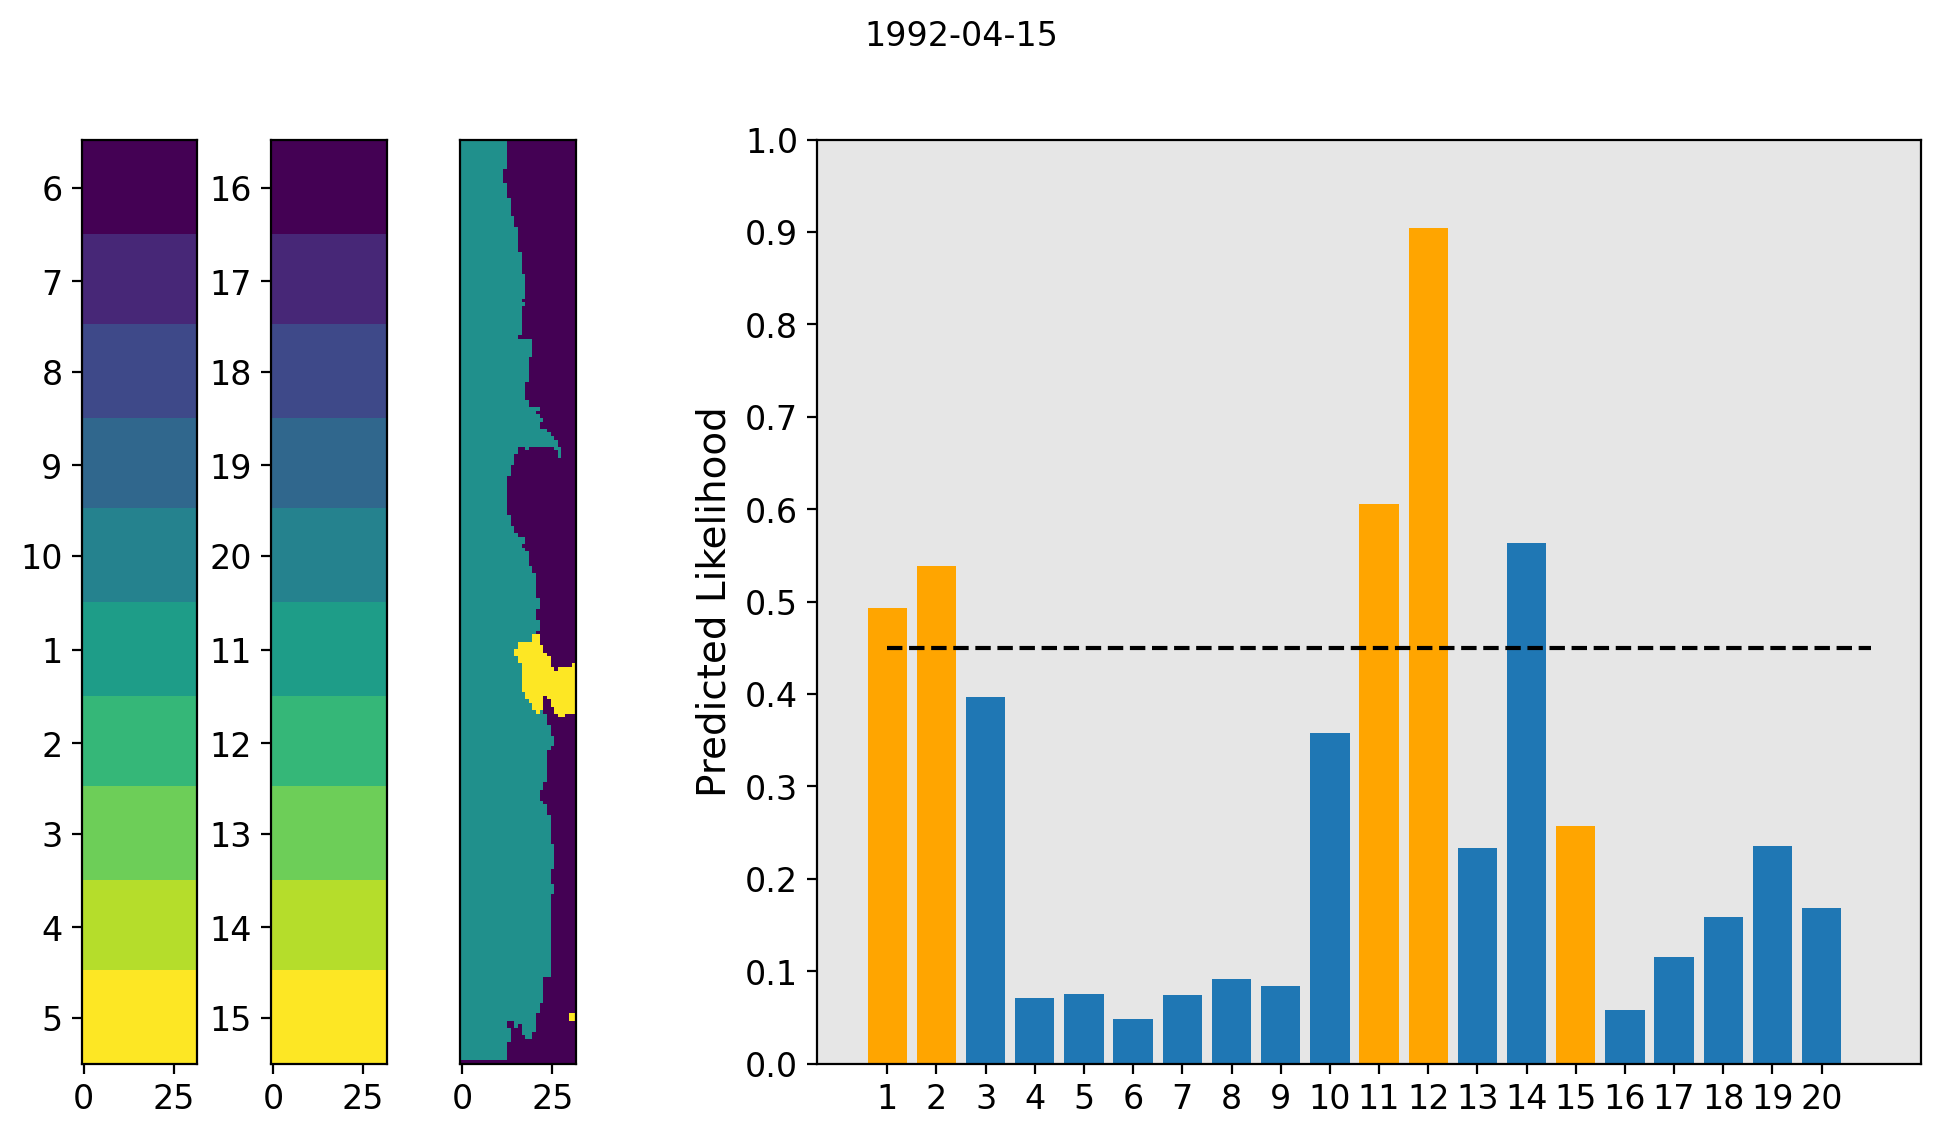

In [13]:
t = 30
time = results.index[t]

Y_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+time[0:4])
Y_data = Y_data.resample(time = '24H').max()
Y_visual_data = xr.where(Y_data.Y>=1000,1, 0) 
Y_visual_data = xr.where(Y_data.Y.isin([100, 101, 110, 111, 1100, 1101, 1110, 1111]),2, Y_visual_data ) 
Y_visual_data = Y_visual_data.sel(time = time).values.T


true_val = val[val.index ==results.index[t]]
true_val = np.array(true_val.columns[true_val.isin([1]).any()], int)

# Make category visual
lons = np.shape(Y_visual_data)[0]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(Y_visual_data)[0],np.shape(Y_visual_data)[1]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

    

fig = plt.figure(figsize=(12, 6), constrained_layout=False)
fig.suptitle(time[0:13])
gs = fig.add_gridspec(1, 10)
ax1 = fig.add_subplot(gs[0, :1])
ax4 = fig.add_subplot(gs[0, 1:2])
ax2 = fig.add_subplot(gs[0,2:3])
ax3 = fig.add_subplot(gs[0, 4:])

# ax1.imshow(show_categories, cmap = 'jet')
# ax4 = ax1.twinx()
ax1.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax1.set_yticklabels(['6','7','8','9','10','1','2','3','4','5',])
# ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax1.imshow(show_categories)


ax4.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax4.imshow(show_categories)


ax2.imshow(Y_visual_data)
ax2.set_yticks([])

ax3.bar(np.arange(0,20,1),results.iloc[t])
ax3.bar(true_val,results.iloc[t][true_val], color = 'orange')
ax3.set_xticks(np.arange(0,20,1), ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']);
ax3.hlines(cutoff, xmin = 0, xmax = 20, linestyles='--', color = 'black')
ax3.set_yticks(np.arange(0,1.1,.1))

ax3.set_ylabel('Predicted Likelihood')
    

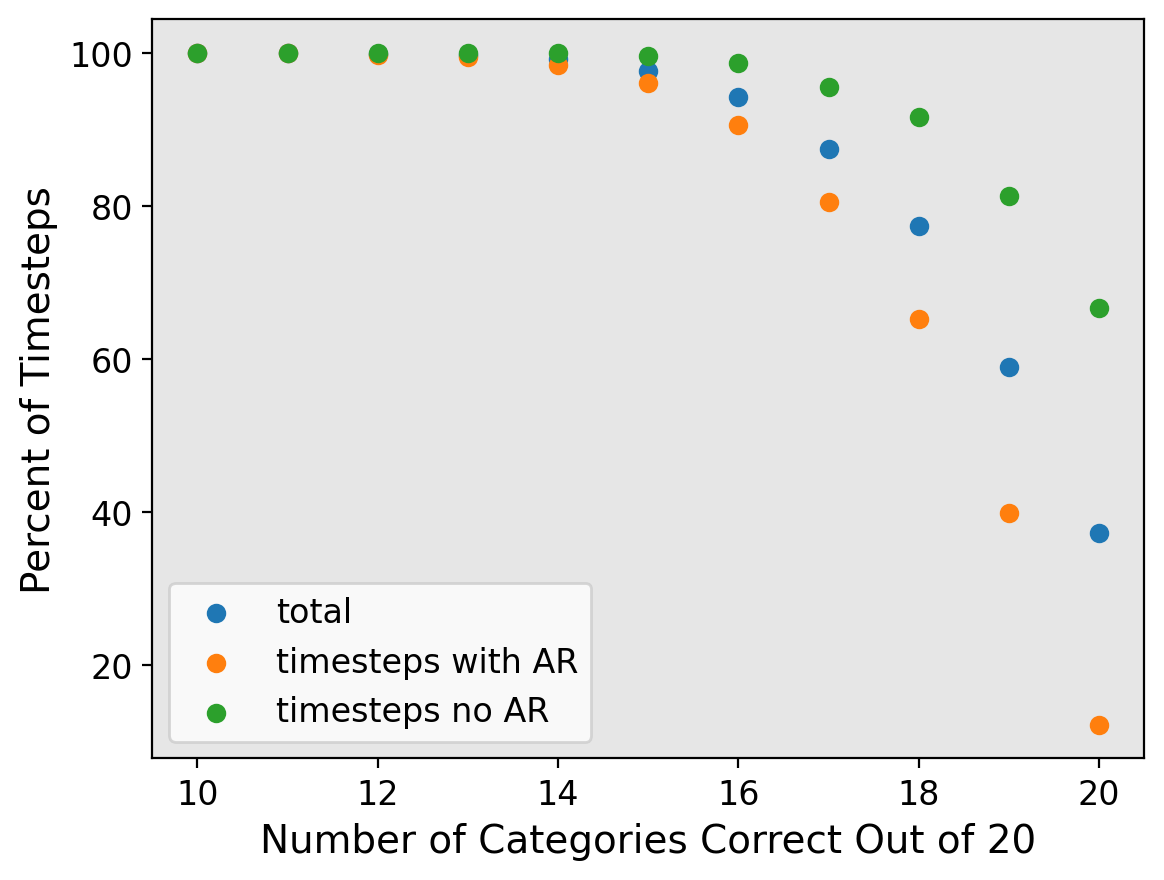

In [93]:
perc_correct_total = []
perc_correct_withAR = []
perc_correct_noAR = []

for n in np.arange(10,21,1):    
    perc_correct_total.append((np.where(np.sum(np.array(predict) == np.array(val),1)>=n,1,0).sum()/len(val)))
    perc_correct_noAR.append((np.where(np.sum(np.array(predict[np.sum(val,1)==0]) == np.array(val[np.sum(val,1)==0]),1)>=n,1,0).sum()/len(val[np.sum(val,1)==0])))
    perc_correct_withAR.append((np.where(np.sum(np.array(predict[np.sum(val,1)>0]) == np.array(val[np.sum(val,1)>0]),1)>=n,1,0).sum()/len(val[np.sum(val,1)>0])))
    
plt.scatter(np.arange(10,21,1), np.array(perc_correct_total)*100, label = 'total')
plt.scatter(np.arange(10,21,1), np.array(perc_correct_withAR)*100, label = 'timesteps with AR')
plt.scatter(np.arange(10,21,1), np.array(perc_correct_noAR)*100, label = 'timesteps no AR')

plt.ylabel('Percent of Timesteps')
plt.xlabel('Number of Categories Correct Out of 20')
plt.legend()

/tmp/ipykernel_26207/3345481459.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.bar(np.argwhere(val.iloc[n] == 1).squeeze(),results.iloc[n][np.argwhere(val.iloc[n] == 1).squeeze()], color = 'orange')


Text(0, 0.5, 'Predicted Likelihood')

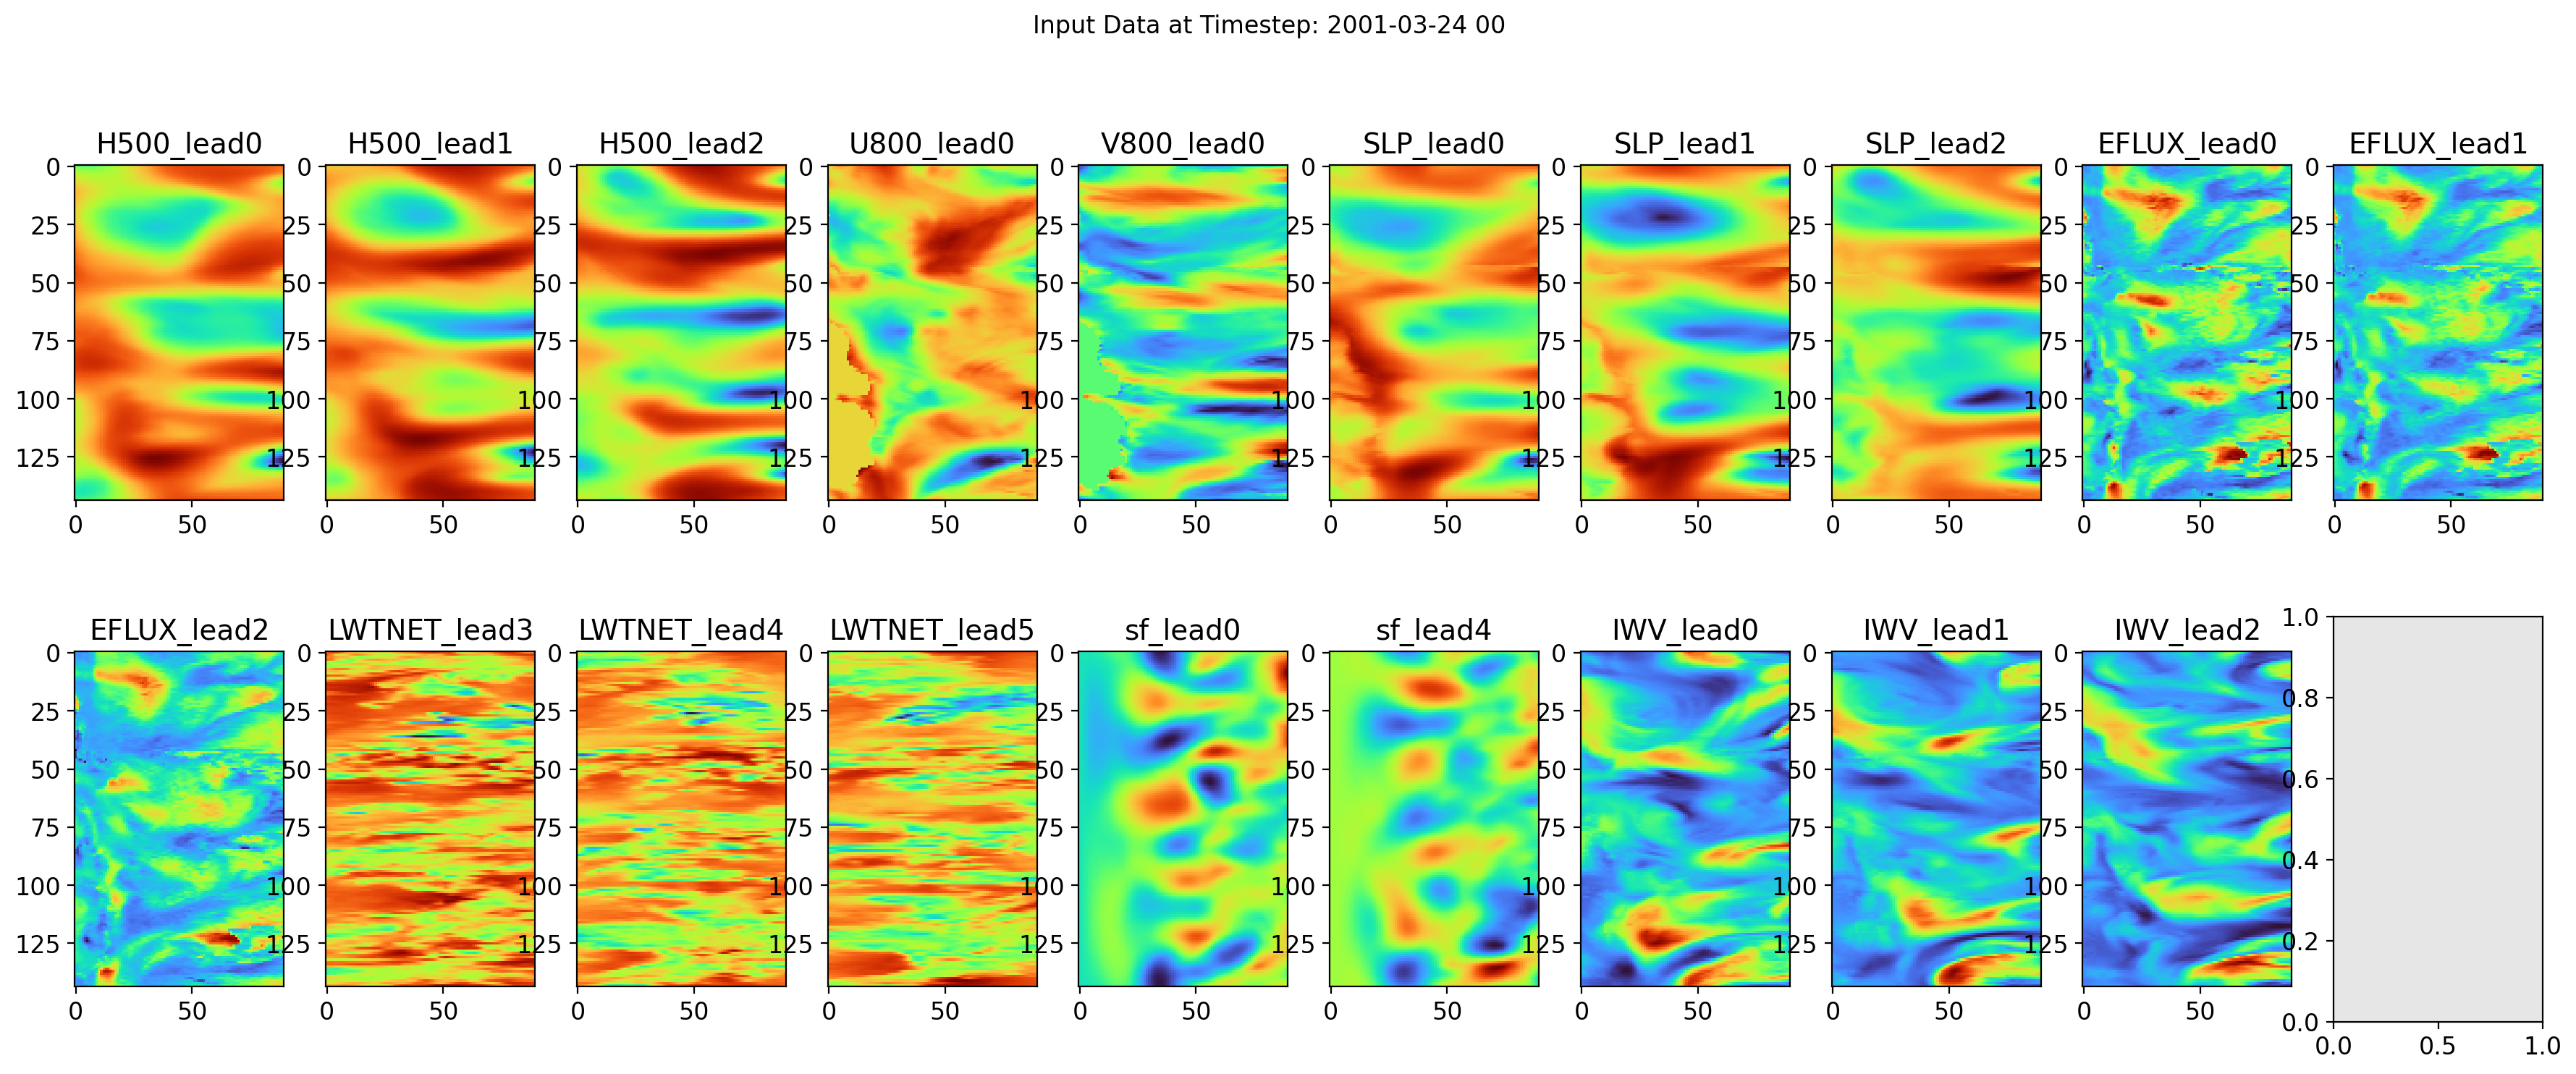

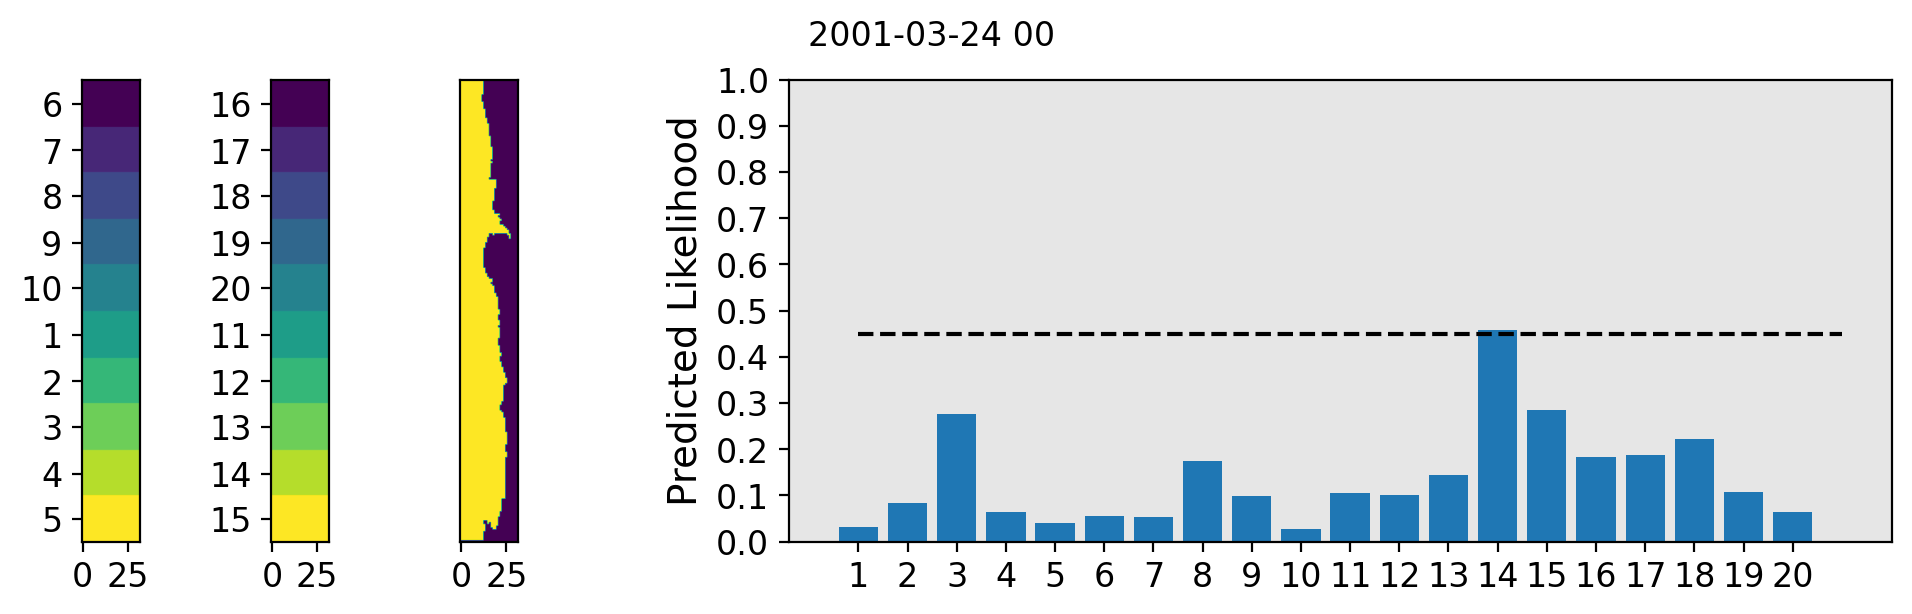

In [17]:
n = 2
time = results.index[n]

X_visual_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate_full.nc')
X_visual_data = X_visual_data.sel(time = pd.to_datetime(time)).load()

Y_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(pd.to_datetime(time).year))
Y_data = Y_data.resample(time = '24H').max()
Y_visual_data = xr.where(Y_data.Y>=1000,1, 0) 
Y_visual_data = xr.where(Y_data.Y.isin([100, 101, 110, 111, 1100, 1101, 1110, 1111]),2, Y_visual_data ) 
Y_visual_data = Y_visual_data.sel(time = time).values.T

# Make category visual
lons = len(X_visual_data.lon)
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(X_visual_data.features)[0:2][1],np.shape(X_visual_data.features)[0:2][0]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

#get the features for example 12 in this batch 
one_example_features = X_visual_data.features
#get the label for that same example 
one_example_label = X_visual_data.labels_1d

titles = [
    'H500_lead0', 'H500_lead1', 'H500_lead2','U800_lead0', 'V800_lead0','SLP_lead0', 'SLP_lead1', 'SLP_lead2',
    'EFLUX_lead0', 'EFLUX_lead1', 'EFLUX_lead2', 'LWTNET_lead3', 'LWTNET_lead4', 'LWTNET_lead5','sf_lead0','sf_lead4',
    'IWV_lead0', 'IWV_lead1', 'IWV_lead2',]


fig,axes = plt.subplots(2,10,figsize=(22,8))
fig.suptitle('Input Data at Timestep: '+str(pd.to_datetime(time))[0:13])
axes = axes.flatten()
for a in range(len(axes)-1):
    axes[a].imshow(one_example_features[:,:,a],cmap='turbo')
    axes[a].set_title(titles[a])

# Make category visual
lons = np.shape(Y_visual_data)[0]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(Y_visual_data)[0],np.shape(Y_visual_data)[1]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

    

fig = plt.figure(figsize=(12, 3), constrained_layout=False)
fig.suptitle(str(pd.to_datetime(time))[0:13])
gs = fig.add_gridspec(1, 10)
ax1 = fig.add_subplot(gs[0, :1])
ax4 = fig.add_subplot(gs[0, 1:2])
ax2 = fig.add_subplot(gs[0,2:3])
ax3 = fig.add_subplot(gs[0, 4:])

# ax1.imshow(show_categories, cmap = 'jet')
# ax4 = ax1.twinx()
ax1.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax1.set_yticklabels(['6','7','8','9','10','1','2','3','4','5',])
# ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax1.imshow(show_categories)


ax4.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax4.imshow(show_categories)


ax2.imshow(Y_visual_data, )
ax2.set_yticks([])

ax3.bar(np.arange(0,20,1),results.iloc[n])
ax3.bar(np.argwhere(val.iloc[n] == 1).squeeze(),results.iloc[n][np.argwhere(val.iloc[n] == 1).squeeze()], color = 'orange')
ax3.set_xticks(np.arange(0,20,1), ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']);
ax3.hlines(cutoff, xmin = 0, xmax = 20, linestyles='--', color = 'black')
ax3.set_yticks(np.arange(0,1.1,.1))
ax3.set_ylabel('Predicted Likelihood')
    

In [18]:
## Checkout certain layer 
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d
1 leaky_re_lu
2 dropout
3 conv2d_1
4 leaky_re_lu_1
5 dropout_1
6 conv2d_2
7 leaky_re_lu_2
8 dropout_2
9 flatten
10 dense
11 dense_1


In [19]:
batch_size = 64
ds_val = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate_full.nc')
val_data = tf.data.Dataset.from_tensor_slices((ds_val.features.values, ds_val.labels_1d.values))
val_data = val_data.batch(batch_size)

for batch in val_data:
    break 



2024-03-27 13:37:31.504547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2191,20]
	 [[{{node Placeholder/_1}}]]


In [ ]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d_2')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(val_data)


35/35 [==============================] - 6s 169ms/step


In [154]:
plot_convolved_images = convolved_images[3]

In [148]:
np.shape(convolved_images)

(2191, 144, 90, 64)

In [146]:
np.shape(plot_convolved_images)

(144, 90, 64)

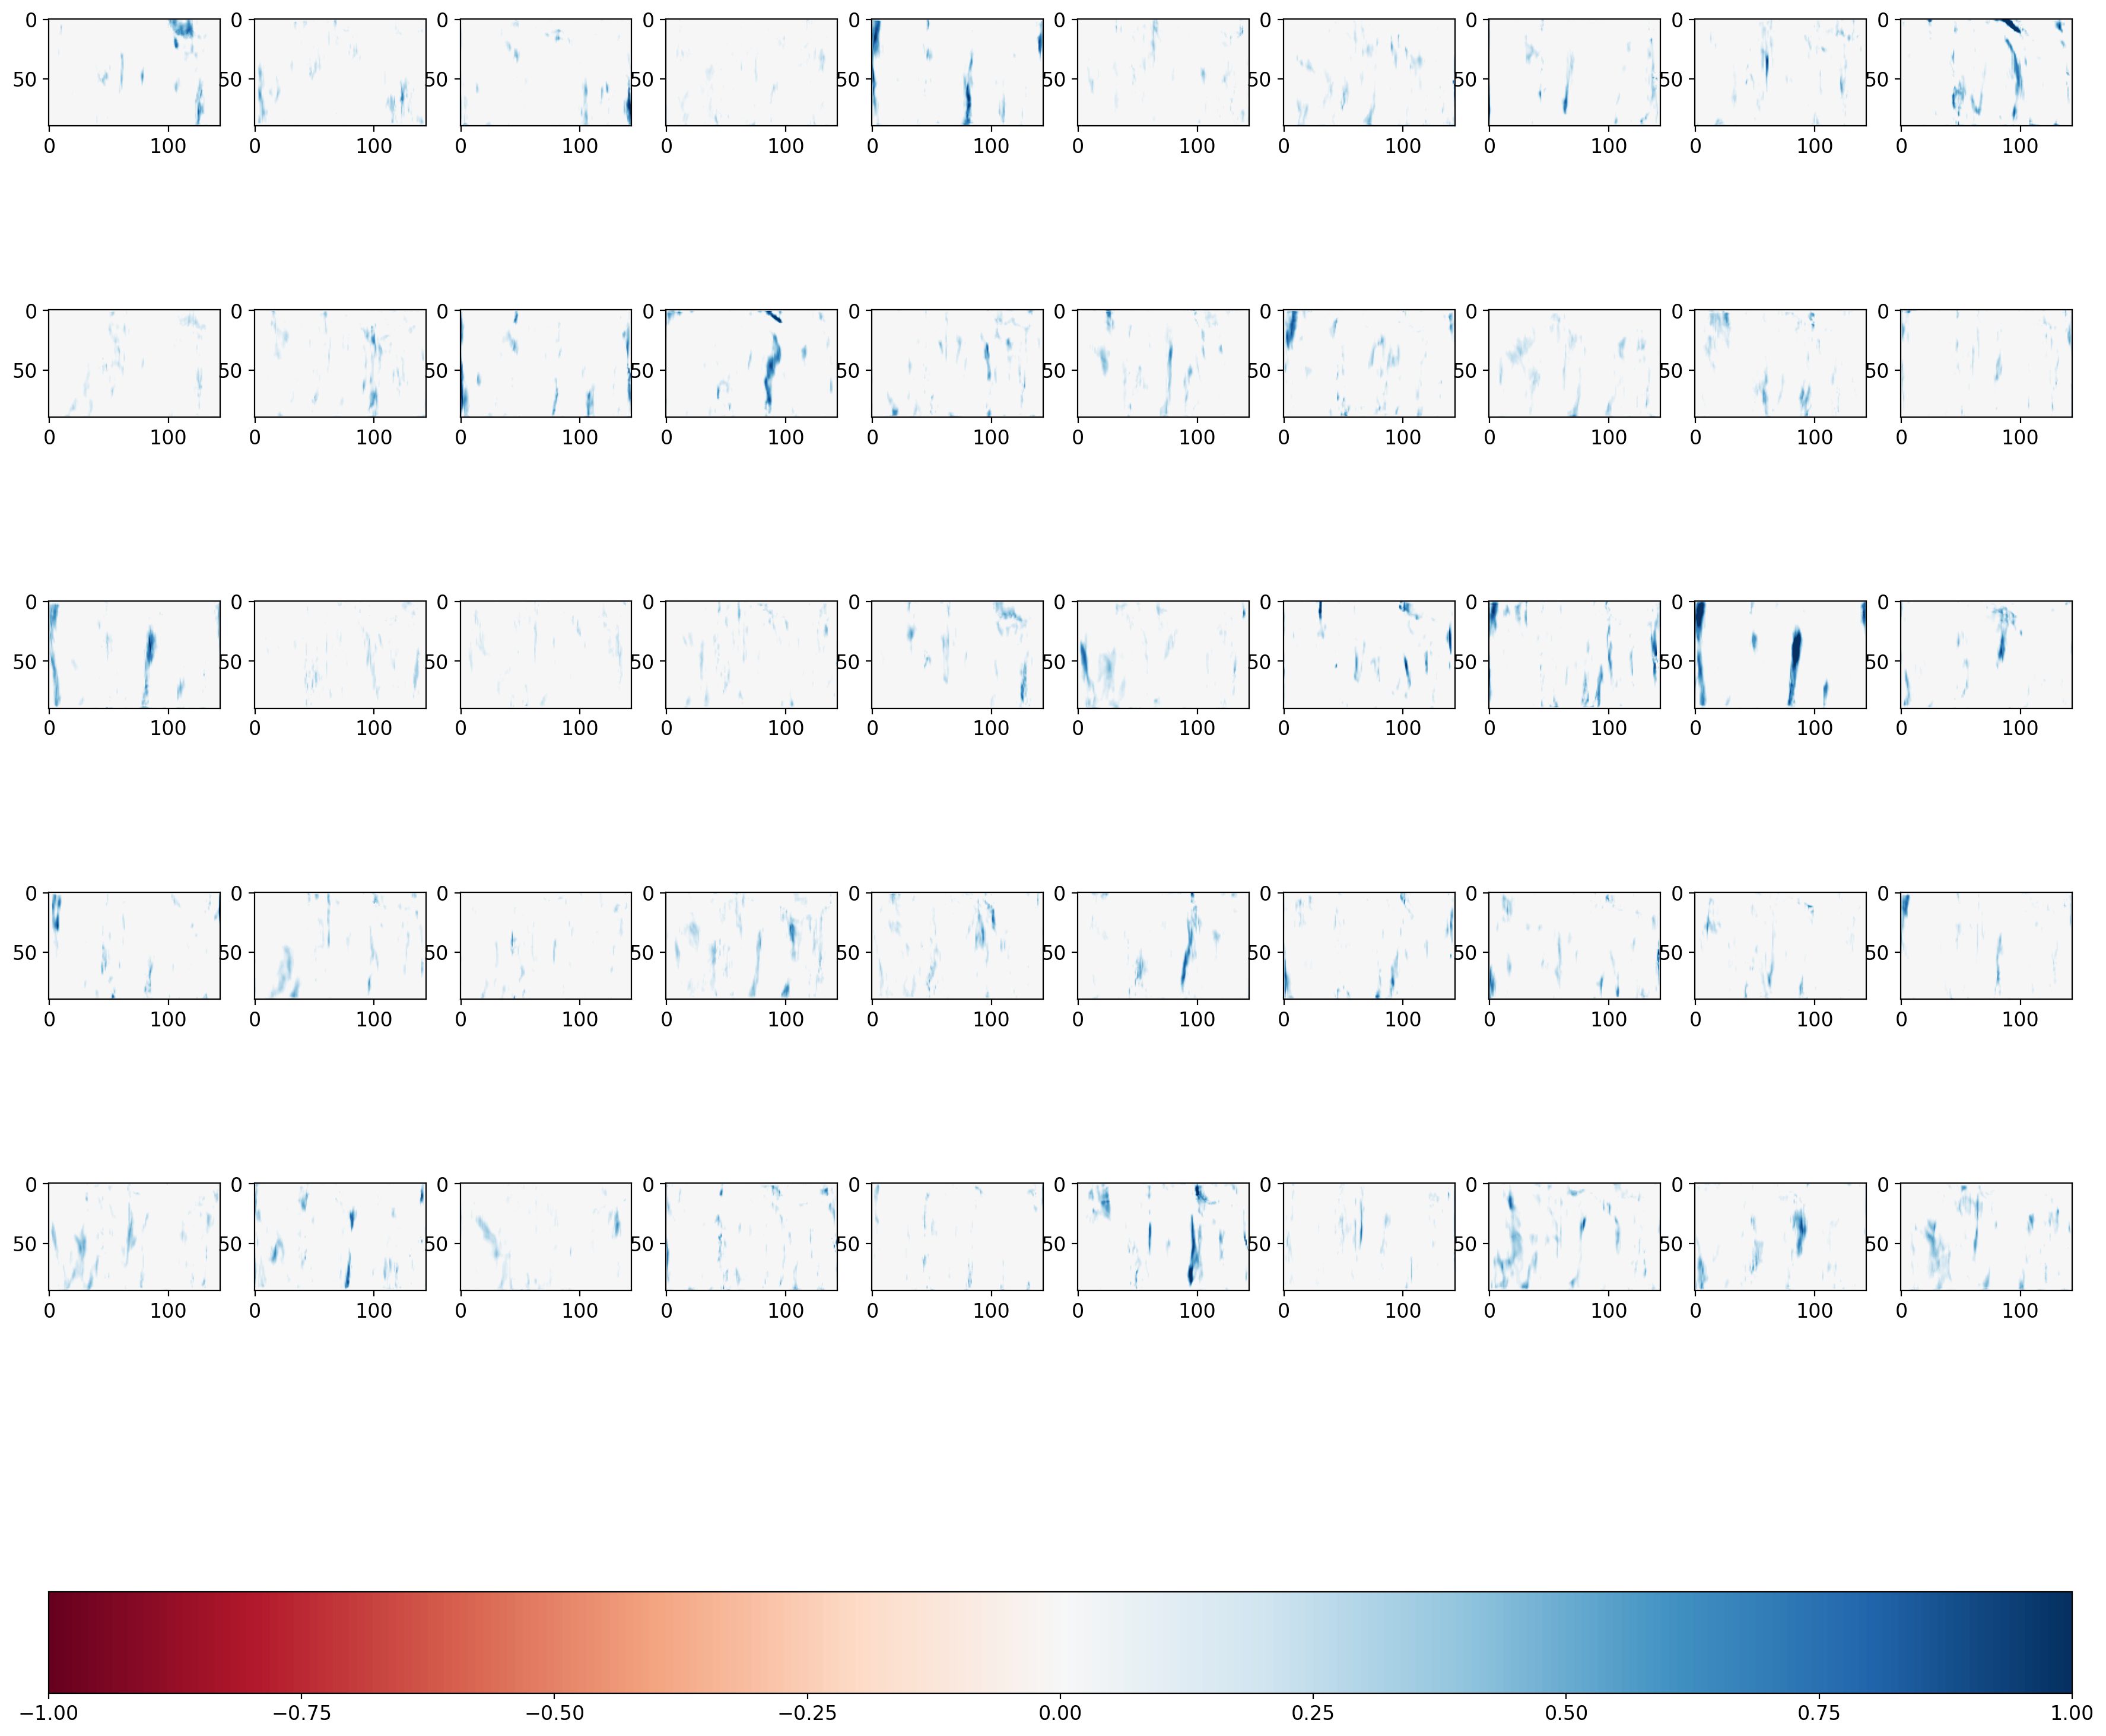

In [155]:

fig,ax = plt.subplots(5,10,figsize=(22,22))
axes = ax.flatten()
for a in range(len(axes)):
    im = axes[a].imshow(plot_convolved_images[:,:,a].T, vmin = -1, vmax = 1,cmap='RdBu')
fig.colorbar(im, ax = axes.ravel(), orientation = 'horizontal')
    

